In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Shift + Enter to run current cell

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras import  backend as K

from subprocess import check_output

In [2]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# separate lables and pixel data
x_train = train.drop(labels = ['label'], axis = 1)
y_train = train['label']

# Feature Scaling, Normalize to (0-1)

Normalization to reduce effects of illumination differences. CNN will work faster. Normalization is reccommended for neural networks over standardization

In [5]:
x_train = x_train / 255.0
test = test / 255.0

print('x_train', x_train.shape)
print('test', test.shape)

x_train (42000, 784)
test (28000, 784)


# Reshape to 28x28

Change to a 28 x 28 x 1 3D matrices with 1 being the black-white (greyscale) value. The first parameter (-1) is simply grabbing the number of images in the dataset

In [6]:
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

print('x_train', x_train.shape)
print('test', test.shape)

x_train (42000, 28, 28, 1)
test (28000, 28, 28, 1)


# Visualize Data

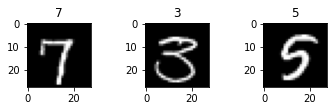

In [7]:
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i]);

# One-Hot-Encode

"With one-hot, we convert each categorical value into a new categorical column and assign a binary value of 1 or 0 to those columns. Each integer value is represented as a binary vector. All the values are zero, and the index is marked with a 1.

One hot encoding is useful for data that has no relationship to each other. Machine learning algorithms treat the order of numbers as an attribute of significance. In other words, they will read a higher number as better or more important than a lower number.

While this is helpful for some ordinal situations, some input data does not have any ranking for category values, and this can lead to issues with predictions and poor performance. That’s when one hot encoding saves the day."

* zero,   one,  two
* 1,      0,      0
* 0,      1,      0
* 0,      0,      1
* 0,      0,      0
* 0,      0,      0
* 0,      0,      0
* 0,      0,      0
* 0,      0,      0
* 0,      0,      0
* 0,      0,      0

num_classes is 10 because the digit can be 0-9

In [8]:
y_train = to_categorical(y_train, num_classes = 10)

# Train Test Split

Define a single variable that contains a static random seed and use it across pipeline in order to reproduce the same randomness everytime the algorithm is run 

In [9]:
seed_value = 3

* test size is 10%
* train size is 90%

**test_sizefloat or int, default=None**
If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size. If train_size is also None, it will be set to 0.25.

10% of the training set will be used as the validation set which the model is evaluated and 90% is used to train the model

We can choose this at random because the dataset is balanced

**random_stateint, RandomState instance or None, default=None**
Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls. 

In [10]:
x_train, x_temptest, y_train, y_temptest = train_test_split(x_train, y_train, test_size = 0.1, random_state = seed_value)

# CNN

Helpful link: https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2

Video on activation functions: https://youtu.be/m0pIlLfpXWE

**Documentation**

Convolution2D layer: This is best explaned in the link above. Usually convolution is done with 3x3 filters, stride 1, with padding. The number of feature maps is also a hyperparameter which you just have to experiment with. From observation of other CNN models for this data 4 or 6 total convolutional layers was common.

MaxPooling2D layer: Also best explained in the link above. 

Dropout (also explained well in the link above) is a technique that drops neurons from the neural network or 'ignores' them during training, in other words, different neurons are removed from the network on a temporary basis. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

Flattening is simply arranging the 3D volume of numbers into a 1D vector


All of the hyperparamters can be messed with once we start evaluating accuracy of the model


In [11]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

2022-08-03 22:13:46.744716: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Set the optimizer and annealer


Three functions: Loss, Optimizing Alg, and score function

Loss function mesures how poorly our model is on images with known values. "It is the error rate between the observed labels and the predicted ones."

Optimizers are used to update the model in repsonse to the output of the loss function. It will iteratively improve values so that it will minimize the loss. Optimizers we can use are RMSprop**, Stochastic Gradient Descent (SGD for short), and Adam(?).

The score function is similair to the loss function in that it will evealuate the performance of the running model but differs from the loss in that the results will not be used when training the mode.

In [12]:
# Define the optimizer (This is using RMS)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [13]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

LEARNING RATE ANNEALING:
https://analyticsindiamag.com/how-to-use-learning-rate-annealing-with-neural-networks/

# Data augmentation

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Evaluating model

In [16]:
# Fit the model
batch_size = 86
epochs = 1
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_temptest,y_temptest),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

2022-08-03 22:13:48.215215: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


439/439 - 90s - loss: 0.3364 - accuracy: 0.8904 - val_loss: 0.0768 - val_accuracy: 0.9752


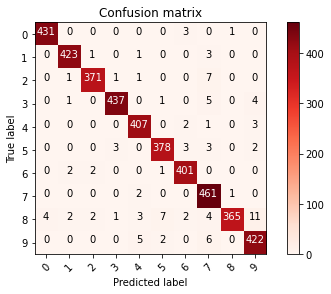

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_temptest)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_temptest,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 